In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/med-qa/train.csv


In [2]:
!pip install torch
!pip install bitsandbytes
!pip install loralib
!pip install transformers
!pip install accelerate
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 6.4 MB/s eta 0:00:00:00:01


In [5]:
df= pd.read_csv('/kaggle/input/med-qa/train.csv')

In [7]:
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
qtype = ' '.join(df['qtype'])
tokens = word_tokenize(qtype)

filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]
fdist = FreqDist(filtered_tokens)

print(fdist.most_common(10))

[('information', 4535), ('symptoms', 2748), ('treatment', 2442), ('inheritance', 1446), ('frequency', 1120), ('genetic', 1087), ('changes', 1087), ('causes', 727), ('exams', 653), ('tests', 653)]


          qtype  Frequency
7   information       4535
1      symptoms       2748
5     treatment       2442
14  inheritance       1446
8     frequency       1120
16      genetic       1087
17      changes       1087
10       causes        727
2         exams        653
3           and        653


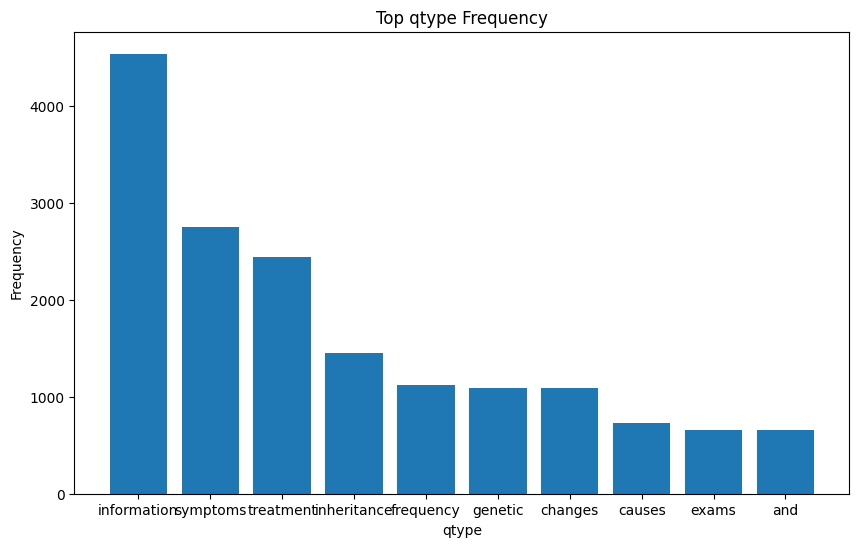

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

qtype_column = df['qtype']

all_qtype = ' '.join(qtype_column.fillna(''))

qtype_tokens = all_qtype.split()

qtype_counts = Counter(qtype_tokens)

qtype_counts_df = pd.DataFrame(list(qtype_counts.items()), columns=['qtype', 'Frequency'])

qtype_counts_df = qtype_counts_df.sort_values(by='Frequency', ascending=False)

top_n = 10
print(qtype_counts_df.head(top_n))

plt.figure(figsize=(10, 6))
plt.bar(qtype_counts_df['qtype'][:top_n], qtype_counts_df['Frequency'][:top_n])
plt.title('Top qtype Frequency')
plt.xlabel('qtype')
plt.ylabel('Frequency')
plt.show()


In [11]:
!pip install vaderSentiment
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:0000:01


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


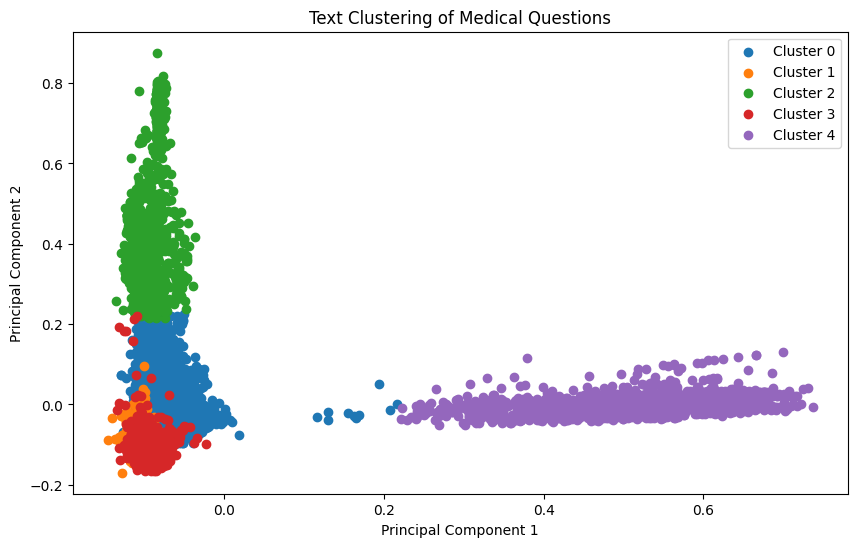

Cluster 0 - Sample Question: What is the outlook for Ataxia ?

Cluster 1 - Sample Question: What are the treatments for oral-facial-digital syndrome ?

Cluster 2 - Sample Question: Is Proud syndrome inherited ?

Cluster 3 - Sample Question: How to prevent Breast Cancer ?

Cluster 4 - Sample Question: What are the symptoms of Pachydermoperiostosis ?



In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

documents = df['Question'].fillna('') + ' ' + df['Answer'].fillna('')

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Apply K-means clustering
num_clusters = 5  # Adjust the number of clusters based on your preference
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize clusters in 2D
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[df['Cluster'] == cluster, 0], X_pca[df['Cluster'] == cluster, 1], label=f'Cluster {cluster}')

plt.title('Text Clustering of Medical Questions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Display sample questions from each cluster
for cluster in range(num_clusters):
    sample_question = df[df['Cluster'] == cluster]['Question'].sample(n=1).values[0]
    print(f"Cluster {cluster} - Sample Question: {sample_question}\n")


In [14]:
!pip install mlxtend==0.23.1
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [15]:
que_conditions = df['Question'].str.lower().str.split(',').apply(lambda x: [s.strip() for s in x])

# One-hot encode the symptoms and conditions
te = TransactionEncoder()
one_hot_encoded = te.fit(que_conditions).transform(que_conditions)
df_encoded = pd.DataFrame(one_hot_encoded, columns=te.columns_)

In [17]:
print(df_encoded.head())

     1 ?    2 ?  20-lyase deficiency ?  20-lyase deficiency inherited ?  \
0  False  False                  False                            False   
1  False  False                  False                            False   
2  False  False                  False                            False   
3  False  False                  False                            False   
4  False  False                  False                            False   

     3 ?    4 ?  4-dienoyl-coa reductase deficiency ?  ab variant ?  \
0  False  False                                 False         False   
1  False  False                                 False         False   
2  False  False                                 False         False   
3  False  False                                 False         False   
4  False  False                                 False         False   

   ab variant inherited ?  acquired ?  ...  x-linked syndrome ?  \
0                   False       False  ...             

In [18]:
print(frequent_itemsets)

    support                                  itemsets
0  0.001219        (what causes causes of diabetes ?)
1  0.001158  (what is (are) high blood cholesterol ?)


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming you have a column named 'Answer' that contains information about treatments
treatments = df['Answer'].dropna().tolist()

# Use TF-IDF Vectorization for text representation
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(treatments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics = 5  # Adjust the number of topics based on your preference
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_keywords = []
for topic_idx, topic in enumerate(lda.components_):
    top_keywords_idx = topic.argsort()[:-10 - 1:-1]  # Top 10 keywords
    top_keywords = [feature_names[i] for i in top_keywords_idx]
    topic_keywords.append(top_keywords)

    print(f"Topic #{topic_idx + 1} Keywords: {', '.join(top_keywords)}")
    print()

# Assign topics to treatments in the dataset
df['Treatment_Topic'] = lda.transform(X).argmax(axis=1)

# Display a sample of treatments with assigned topics
sample_treatments = df[['Answer', 'Treatment_Topic']].sample(10)
print("Sample Treatments with Assigned Topics:")
print(sample_treatments)

Topic #1 Keywords: gene, condition, autosomal, inherited, copy, recessive, pattern, cell, copies, mutations

Topic #2 Keywords: treatment, cancer, blood, people, disease, 000, risk, prevalence, symptoms, health

Topic #3 Keywords: syndrome, gene, mutations, protein, cells, individuals, affected, symptoms, cause, brain

Topic #4 Keywords: symptom, frequency, number, patients, 90, information, 25, sign, study, available

Topic #5 Keywords: genetic, diagnosis, resources, management, testing, registry, review, medlineplus, counseling, rehabilitation

Sample Treatments with Assigned Topics:
                                                  Answer  Treatment_Topic
11667  Is genetic testing available for hereditary mu...                1
1795   Signs and symptoms of Whipple disease can vary...                2
14315  Fanconi Bickel syndrome (FBS) is a rare glycog...                2
86     Public education about botulism prevention is ...                1
14807  Trichorhinophalangeal syndrome

In [ ]:
!pip uninstall torch torchvision transformers
!pip install torch torchvision transformers

Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Would remove:
    /opt/conda/bin/convert-caffe2-to-onnx
    /opt/conda/bin/convert-onnx-to-caffe2
    /opt/conda/bin/torchrun
    /opt/conda/lib/python3.10/site-packages/functorch/*
    /opt/conda/lib/python3.10/site-packages/torch-2.2.2.dist-info/*
    /opt/conda/lib/python3.10/site-packages/torch/*
    /opt/conda/lib/python3.10/site-packages/torchgen/*
Proceed (Y/n)? 

In [7]:
from huggingface_hub import notebook_login

In [9]:
notebook_login()

In [10]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
!pip install -U bitsandbytes

In [11]:

MODEL_NAME = "GeneZC/MiniChat-1.5-3B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.04G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/749k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

In [61]:

def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [62]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [63]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    
)

model = get_peft_model(model, config)

print_trainable_parameters(model)

In [64]:
prompt = """
<human>: what can i do to prevent poisoning by marine toxins?
<Assistant>:
""".strip()

In [65]:
generation_config = model.generation_config
generation_config.max_new_tokens = 2056
generation_config.temperature = 0.4
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [83]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [67]:
from datasets import Dataset, DatasetDict

subset_df = df.head(30)

subset_dataset = Dataset.from_pandas(subset_df)

train_data = DatasetDict({'train': subset_dataset})

print(train_data)

In [68]:
def generate_prompt(data_point):
    return f"""
    : {data_point["Question"]}
    : {data_point["Answer"]}
    """.strip()

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    return tokenized_full_prompt

# Shuffle and apply the function to the training data
train_data_transformed = train_data["train"].shuffle().map(generate_and_tokenize_prompt)

# Print the transformed dataset
print(train_data_transformed)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [69]:
training_args = transformers.TrainingArguments(
      per_device_train_batch_size=4,
      gradient_accumulation_steps=4, 
      num_train_epochs=2,
      learning_rate=2e-4,
      fp16=True,
      save_total_limit=3,
      logging_steps=500,
      output_dir="MiniMedicXpert",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
      push_to_hub=True,
)

In [70]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data_transformed,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss


TrainOutput(global_step=4, training_loss=2.0604677200317383, metrics={'train_runtime': 275.8293, 'train_samples_per_second': 0.218, 'train_steps_per_second': 0.015, 'total_flos': 494069872877568.0, 'train_loss': 2.0604677200317383, 'epoch': 2.0})

In [71]:
model.save_pretrained("trained-model")


In [72]:
import shutil

trained_model_path = "/kaggle/working/trained-model"

shutil.make_archive(trained_model_path, 'zip', trained_model_path)


'/kaggle/working/trained-model.zip'

In [73]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(49216, 3072, padding_idx=0)
        (layers): ModuleList(
          (0-23): 24 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_

In [74]:
trained_model_path = "/kaggle/working/trained-model"

shutil.make_archive("/kaggle/working/trained", 'zip', "/kaggle/working/trained-model")

'/kaggle/working/trained.zip'

In [75]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [76]:
outputs[0]

tensor([    1,   529, 26029, 23917,   825,   508,   474,   437,   304,  5557,
        27908,   292,   491, 23585,   304, 29916,  1144, 29973,    13, 29966,
         7900, 22137, 23917,  1763,  5557, 27908,   292,   491, 23585,   304,
        29916,  1144, 29892,   372,   338, 18853,   304,  1101,  1438,  1410,
        10652,  1475, 29901,    13, 29896, 29889,   319,  5405,   321,  1218,
        10650,   470,  1090,  1111, 12504,  7205,  1181,   397, 29892,  7148,
         6473, 15161, 29892,  9427, 29892,   322,  7205,   705,   287, 29889,
           13, 29906, 29889, 17278,  7205,  1181,   397, 26606, 29892,  7148,
         6473, 15161, 29892,   304, 12088,   738,   610,   294,  3246,   470,
          289,  5761,   423,   393,  1122,   367,  2198, 29889,    13, 29941,
        29889,  5399,   278,  1518, 12232,  2635,   322,   671,   871, 10849,
         7205,  1181,   397, 29889,    13, 29946, 29889,   319,  5405,   321,
         1218,  7205,  1181,   397,   515, 21180,  3860,   470, 

In [79]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'<human>: what can i do to prevent poisoning by marine toxins?\n<Assistant>: To prevent poisoning by marine toxins, it is essential to follow these guidelines:\n1. Avoid eating raw or undercooked seafood, especially shellfish, fish, and seaweed.\n2. Cook seafood thoroughly, especially shellfish, to kill any parasites or bacteria that may be present.\n3. Check the expiration date and use only fresh seafood.\n4. Avoid eating seafood from polluted or contaminated waters.\n5. If you are unsure about the safety of a particular seafood item, do not eat it.\n6. If you suspect you have eaten contaminated seafood, seek medical attention immediately.\n7. If you have a history of seafood poisoning, avoid consuming raw or undercooked seafood.\n8. If you are pregnant or breastfeeding, avoid consuming raw or undercooked seafood, as it may contain harmful toxins.\n9. If you have a history of allergies or sensitivities to seafood, avoid consuming seafood that may cause an allergic reaction.\n10. If yo

In [80]:
sol= tokenizer.decode(outputs[0], skip_special_tokens=True)